# Property and Renters Insurance in Florida - Visualized 3 Ways

### This project seeks to locate, clean, and plot data that show changes in the Florida Insurance market over time, from 2016 - 2023. Three different plots were created, to demonstrate various methods of visualization, as well as an interative process of review and improvement.

### This summary includes the Python code used to conduct the analysis and construct the visualizations, some brief annotation of the code, and some additional commentary on the design of each visualization.  

#### Competencies:
1. Data Acquisition and Cleaning
2. Basic Data Analysis with pandas and numpy
3. Data Visualization with matplotlib


<!-- : considerable research and time was spent finding and downloading public data on the Florida insurance market.  Cleaning the data required use of some basic Python techniques.<br>Data Analysis and Visualization: this project highlights various methods of data visualization using the Pandas and Matplotlib Python libraries. The same data is analyzed and plotted in three different ways.  -->

#### Data Sources:
1. The Florida Office of Insurance Regulation<br>https://apps.fldfs.com/QSRNG/Reports/ReportCriteriaWizard.aspx
2. The United States Census<br>https://www.census.gov/data/datasets.html

#### Limitations:
The Florida Office of Insurance Regulation (OIR) data is unfortunately incomplete. Due to a 2014 lawsuit (decided in 2017), insurance companies operating in Florida are no longer required to disclose any information to the OIR. The majority of companies still report their data, however the missing data renders this analysis unreliable as a means of understanding the reality of the Florida insurance market. 


In [22]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#### Data Cleaning and Analysis
The data available from the Florida OIR is organized quarterly, and must be downloaded on year at a time.  The 8 separate csv files were concatenated into one DataFrame, then cleaned and organized.  

The first visualization includes a plot of Florida population data over time, to provide more context for the insurance data.  This population data, provided by the US Census Bureau, is annual (not quarterly) and thus required some cleaning and simple interpolation to align with the insurance data.  

In [391]:
filenames = [
    '2016_QSR_FLins.csv',
    '2017_QSR_FLins.csv',
    '2018_QSR_FLins.csv',
    '2019_QSR_FLins.csv',
    '2020_QSR_FLins.csv',
    '2021_QSR_FLins.csv',
    '2022_QSR_FLins.csv',
    '2023_QSR_FLins.csv'
]

dfs = []
for file in filenames:
    df = pd.read_csv(file, header=2)
    dfs.append(df)

dfall = pd.concat(dfs)
dfall.rename(columns = {'textbox7':'Q_End_Date'}, inplace=True)
dfall.replace({',':'', 'Period Ending  ':''}, regex=True, inplace=True)
dfall['Q_End_Date'] = pd.to_datetime(dfall['Q_End_Date'])

dfall['PIF_TOT'] = dfall['PIF_TOT'].astype('int64')

dfbytype = dfall.groupby(['POLICY_TYPE_NM', 'Q_End_Date']).sum().unstack(level=0)

totals = dfbytype['PIF_TOT'].drop(columns=['Personal Residential - Excess Private Flood', 'Personal Residential - Primary Private Flood'])

categories = {
    'Owners' : totals.iloc[:, 9:21].sum(axis=1),
    'Renters' : totals.iloc[:, 21:].sum(axis=1)
}

totals_category = pd.DataFrame(data=categories)

In [81]:
#population data is edited and re-indexed to match the insurance data
pop1 = pd.read_csv('pop2010_2020.csv')
pop2 = pd.read_csv('pop2020_2022.csv')

pop1.drop(columns = ['POPESTIMATE042020'], inplace=True)

population = pd.DataFrame(pd.concat([dfpop2.iloc[23,7:9], dfpop1.iloc[14,13:]]).sort_index(), columns=['Population'])

#reindex to match the last-day of the first quarter of each year, since insurance data is quarterly. 
popindex = pd.to_datetime(['2016-03-31', '2017-03-31',
               '2018-03-31', '2019-03-31',
               '2020-03-31', '2021-03-31',
               '2022-03-31'])
population.set_index(popindex, inplace=True)

In [84]:
final = totals_category.merge(population, how='left', right_on=popindex, left_index=True).rename(columns={'key_0': 'Date'})
final.set_index('Date', inplace=True)
final['Population'] = final['Population'].astype('float').interpolate(method='linear')
final['Total'] = final['Owners'] + final['Renters']

#### Figure 1
#### The first figure created uses two subplots which share a single x-axis; population numbers and insurance policy numbers both plotted over the same time period (2016 - 2023).  

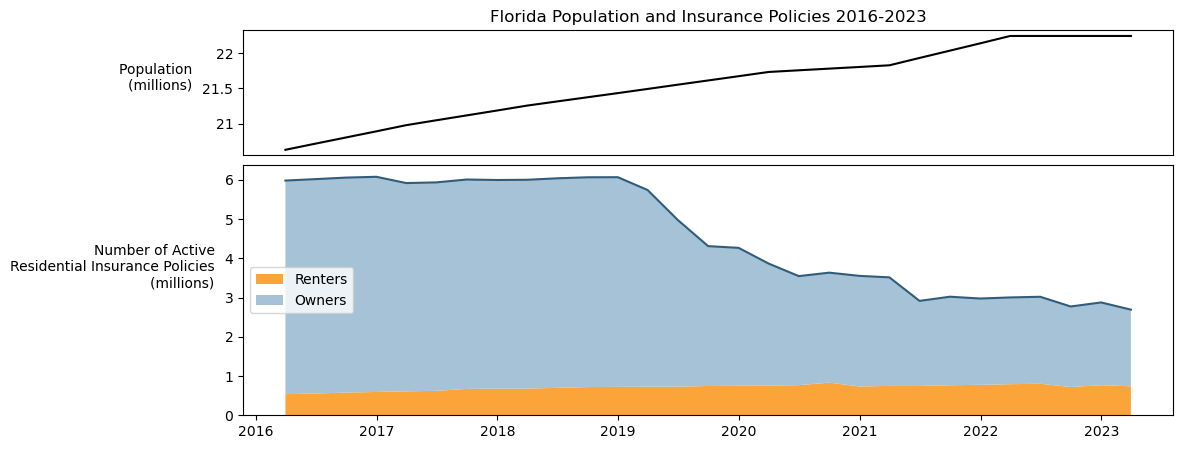

In [518]:
#one figure and 2 axes created to subplot the insurance data and the population data
fig,(ax1, ax2) = plt.subplots(2,1,figsize=(12,5), gridspec_kw={'height_ratios':[1,2], 'hspace':0.05})

#set title to axis1
ax1.set_title('Florida Population and Insurance Policies 2016-2023')

#plot data, including a second plot on ax2 to add a kind of border/highlight to the top of the stackplot
ax1.plot(final['Population'], color='black')
ax2.stackplot(final.index, final.iloc[:,1], final.iloc[:,0], baseline='zero', labels=['Renters', 'Owners'], colors=['#faa439', '#a5c2d6'])
ax2.plot(final['Total'], color='#325d7a')

#plotting the desired tick locations and labels required setting them manually
ax1.set_xticks([])
ax1.set_ylabel('Population \n(millions) ', rotation='horizontal', ha='right')

ax1.set_yticks(ax1.yaxis.get_majorticklocs()[1:4],[21, 21.5, 22])
ax2.set_yticks(ax2.yaxis.get_majorticklocs()[0:7],np.arange(0,7,1))

ax2.set_ylabel('Number of Active \nResidential Insurance Policies \n(millions) ', rotation='horizontal', ha='right')

ax2.legend(loc=6)

#### Figure 1 (above) aims to show changes in population against changes in the number of active insurance policies.  Essentially to make the point that while population is increasing, the number of active insurance policies is decreasing.
#### While that contrast is evident, the figure leaves vague much of the detail within the insurance data itself. Furthermore, given the limitations detailed at the beginning of this project, the contrast between population and insurance policy data is less impactful if the reader is aware that the insurance policy data is not actually reflective of the entire insurance policy market in Florida.  Thus the potential conclusion that "More people live in Florida, but fewer people have insurance policies" indicated by this figure is not valid.  

#### Figure 2 aims to focus the analysis on just the insurance data, and provide more detail about that data. It also aims to present a more simple, less crowded, visual to the reader.   

In [397]:
x = totals_category.groupby(totals_category.index.year).mean().astype('int')
x['pch_o'] = ((x['Owners']/x.iloc[0,0])*100 - 100).astype('int')
x['pch_r'] = ((x['Renters']/x.iloc[0,1])*100 - 100).astype('int')

Text(0.56, 0.83, 'Individual Policies for Home Owners and Renters Separated')

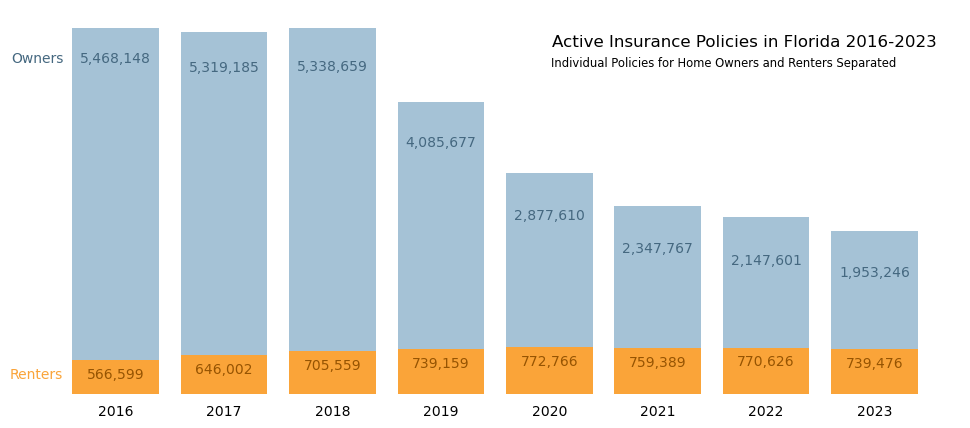

In [473]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
#fig,(ax, ax2) = plt.subplots(2,1,figsize=(20,5), gridspec_kw={'height_ratios':[2,1], 'hspace':0.25})

ax.bar(x['Owners'].index, height=x['Owners'].values, bottom = x['Renters'].values, color='#a5c2d6')
ax.bar(x['Owners'].index, height=x['Renters'].values, color='#faa439')

#get rid of spines, ticks, labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(left=False, bottom=False)
ax.set_yticks([])

xticks = ax.xaxis.get_majorticklocs()

for num in list(range(8)):
    ax.annotate((f"{(x.iloc[num,0]):,}"), (xticks[num+1],x.iloc[num,0]), ha='center', color='#456880')
    ax.annotate((f"{(x.iloc[num,1]):,}"), (xticks[num+1],(x.iloc[num,1]-300000)), ha='center', color='#965402')
    

plt.annotate('Owners', (xticks[1]*0.99976, x.iloc[0,0]), ha='right', color='#456880')
plt.annotate('Renters', (xticks[1]*0.99976, x.iloc[0,1]-300000), ha='right', color='#faa439')
plt.suptitle('Active Insurance Policies in Florida 2016-2023',x=0.72, y=0.83)
plt.title('Individual Policies for Home Owners and Renters Separated', x=0.56, y=0.83, fontsize='small', ha='left')
#(Note: Florida Office of Insurance Regulation data is only \n a sample of total policies in the state)

#### In comparison to the Figure 1, Figure 2 (above) presents more detail about the insurance data in a more spartan ('cleaner') visual.  The precipitous drop of property insurance policies and the concurrent rise in renter insurance policies are made much clearer by the inclusion of the actual annual totals within each bar of the chart.  

Text(2016.5966, 17, 'Renters')

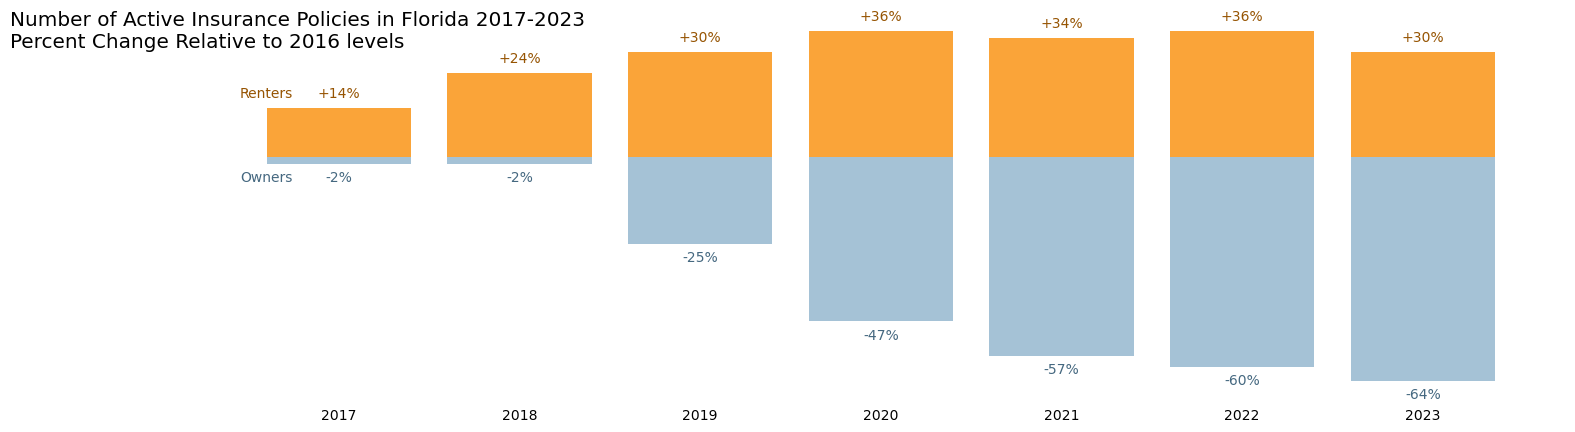

In [504]:
fig,ax2 = plt.subplots(figsize=(20,5))

ax2.bar(x['Owners'].index, height=x['pch_o'], color='#a5c2d6')
ax2.bar(x['Owners'].index, height=x['pch_r'], color='#faa439')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
plt.tick_params(left=False, bottom=False)
ax2.set_yticks([])
#ax2.set_xticklabels(ax2.xaxis.get_majorticklocs(),color='white')

xticks = ax2.xaxis.get_majorticklocs()
ax2.set_xticks(xticks[2:9])

for num in np.arange(1,8,1):
    plt.annotate((f"{(x.iloc[num,2]):,}"+"%"), (xticks[num+1],x.iloc[num,2]-5), ha='center', color='#456880')
    plt.annotate(("+"+f"{(x.iloc[num,3]):,}"+"%"), (xticks[num+1],(x.iloc[num,3]+3)), ha='center', color='#965402')

ax2.set_ylabel("Number of Active Insurance Policies in Florida 2017-2023 \nPercent Change Relative to 2016 levels", x=.75, y=.9, ha='left', fontsize='x-large',rotation='horizontal')

ax2.annotate("Owners", (xticks[2]*0.9998,x.iloc[1,2]-5), ha='center', color='#456880')
ax2.annotate("Renters", (xticks[2]*0.9998,(x.iloc[1,3]+3)), ha='center', color='#965402')

#### Figure 3 (above) aims to represent the same data as Figure 2, but in terms of percentage change.  The same design and color style was maintained, but the contrast of positive and negative trends is more visually evident with the diverging bars (down for negative and up for positive).  And the total percent change over time is -as a single number-  easier to understand and communicate in a more impactful way. 